Import the required libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

Load the Image data

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Image Classification Intel/archive_5.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
train_dataset_path = '/tmp/seg_train/seg_train'
validation_dataset_path = '/tmp/seg_test/seg_test'

Applying Augmentation on images

In [ ]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')


train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 14034 images belonging to 6 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                              target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='categorical',
                                                              shuffle=True)

Found 3000 images belonging to 6 classes.


label mapping

In [ ]:
labels = {value:key for key, value in train_generator.class_indices.items()}

In [ ]:
print('Labels Mappings for classes \n')

for key, value in labels.items():
  print(f'{key} : {value}')

Labels Mappings for classes 

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


In [ ]:
labels.items()

dict_items([(0, 'buildings'), (1, 'forest'), (2, 'glacier'), (3, 'mountain'), (4, 'sea'), (5, 'street')])

Plotting sample images

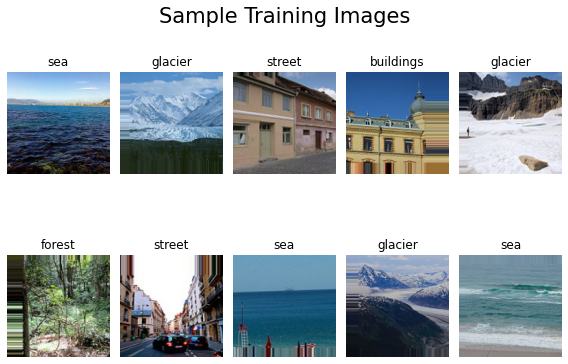

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(8,6))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

Train the CNN Model

In [ ]:
# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(150,150, 3)))

# convolutional layer
model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(6, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model for 10 epochs
model.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
439/439 [==============================] - 137s 307ms/step - loss: 1.2924 - accuracy: 0.5075 - val_loss: 1.0182 - val_accuracy: 0.6123
Epoch 2/20
439/439 [==============================] - 130s 297ms/step - loss: 0.9487 - accuracy: 0.6250 - val_loss: 0.8931 - val_accuracy: 0.6690
Epoch 3/20
439/439 [==============================] - 130s 296ms/step - loss: 0.8512 - accuracy: 0.6754 - val_loss: 0.6313 - val_accuracy: 0.7757
Epoch 4/20
439/439 [==============================] - 128s 292ms/step - loss: 0.7354 - accuracy: 0.7314 - val_loss: 0.5724 - val_accuracy: 0.7953
Epoch 5/20
439/439 [==============================] - 129s 293ms/step - loss: 0.6881 - accuracy: 0.7493 - val_loss: 0.5643 - val_accuracy: 0.7907
Epoch 6/20
439/439 [==============================] - 128s 292ms/step - loss: 0.6494 - accuracy: 0.7656 - val_loss: 0.5130 - val_accuracy: 0.8090
Epoch 7/20
439/439 [==============================] - 128s 291ms/step - loss: 0.6040 - accuracy: 0.7804 - val_loss: 0.4795 -

Testing on test dataset

In [ ]:
test_dataset = '/tmp/seg_test/seg_test'

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 3000 images belonging to 6 classes.


In [ ]:
predictions = model.predict(test_generator)

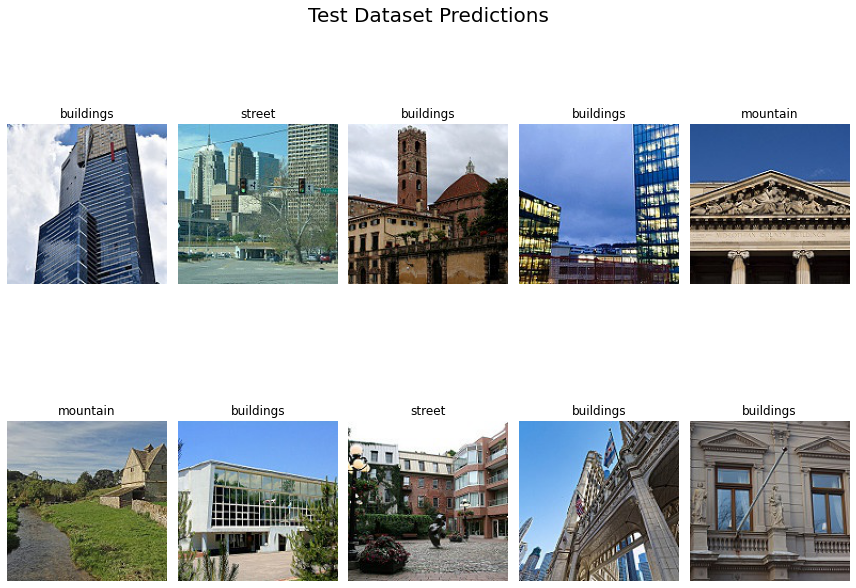

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=BATCH_SIZE)

94/94 [==============================] - 7s 70ms/step - loss: 0.3905 - accuracy: 0.8567


In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.3905176520347595
Test Accuracy: 0.8566666841506958


Plotting Confusion Matrix

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

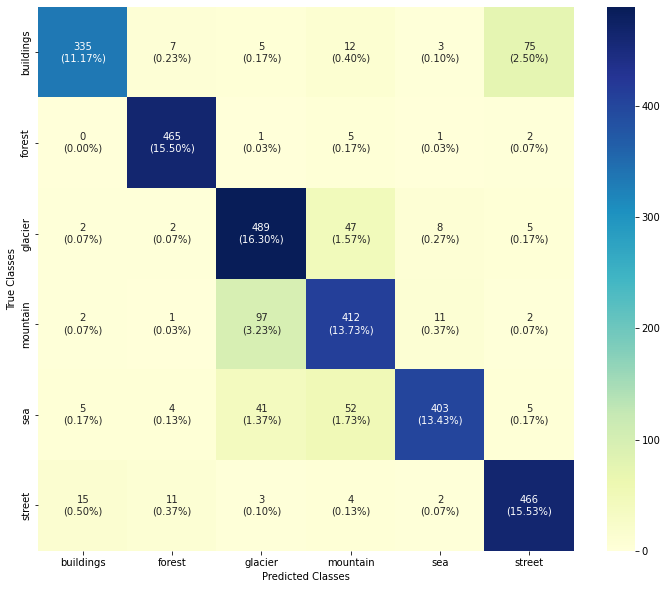

In [ ]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(6, 6)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

   buildings       0.93      0.77      0.84       437
      forest       0.95      0.98      0.96       474
     glacier       0.77      0.88      0.82       553
    mountain       0.77      0.78      0.78       525
         sea       0.94      0.79      0.86       510
      street       0.84      0.93      0.88       501

    accuracy                           0.86      3000
   macro avg       0.87      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



Let's see where the model has given wrong predictions and what were the actual predictions on those images.

In [ ]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [ ]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

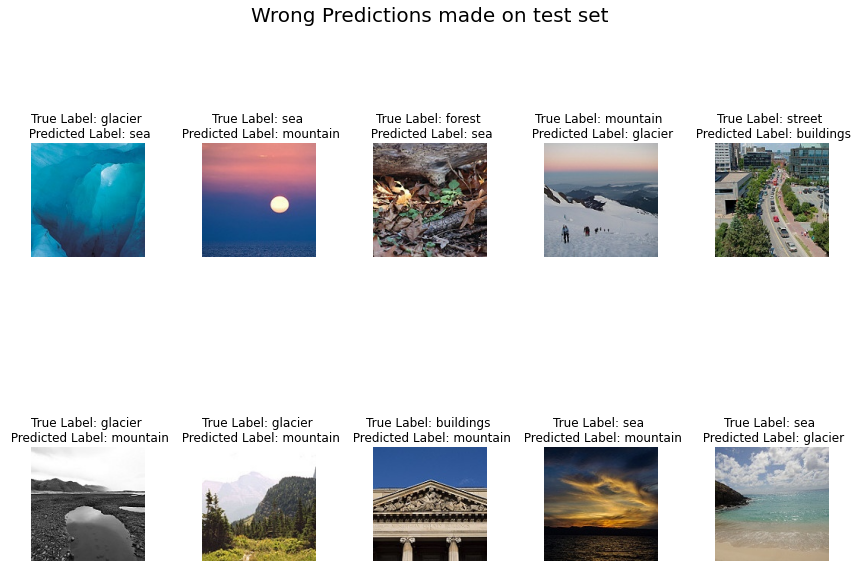

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()
